# Redes Neuronales con TensorFlow

## TensorFlow

TensorFlow es una de las opciones más utilizadas a la hora de desarrollar Deep Learning o Machine Learning; sin embargo, existen otras bibliotecas relevantes en el desarrollo de la IA como Caffe, Pytorch, GLUON, entre otras.

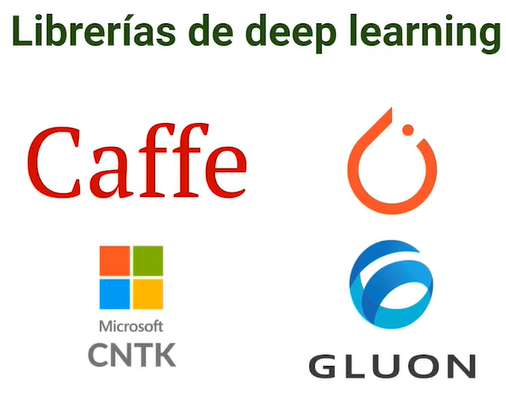

El nombre TensorFlow surge de la combinación de las palabras Tensor (estructura de datos principal a la hora de trabajar con Redes Neuronales) y Flow (el flujo de procesos durante el ciclo de vida del Machine Learning); se puede entender cada paso del modelo como un nodo que está agrupado mediante una lógica de grafos

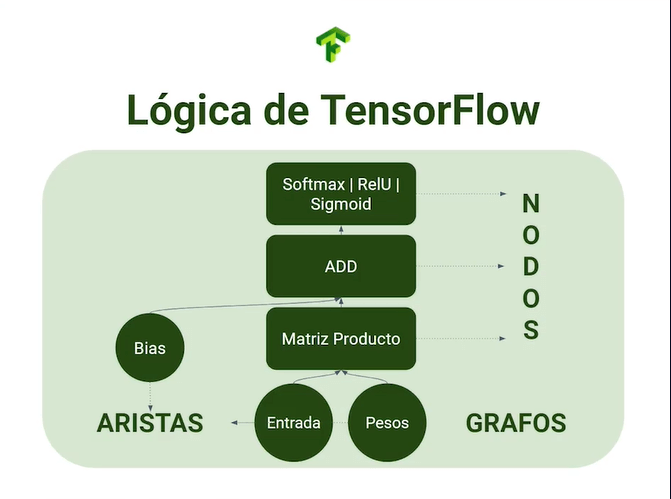

Para sintetizar el proceso de creación de modelos de Deep Learning, François Chollet desarrolló Keras como API para TensorFlow: una herramienta que oculta la matemática del proceso y permite crear modelos altamente efectivos con pocas líneas de código.

## Manejo y Preprocesamiento de datos

Los datos son el motor de la Inteligencia Artificial. 

La calidad de los datos será directamente proporcional al desempeño del modelo: si los datos que entran no son buenos, entonces el modelo no será efectivo; esto es el concepto GIGO (Garbage In Garbage Out).

El preprocesamiento de los datos es tan importante como la calidad de los mismos, por lo que es necesario limpiar aquellos datos corruptos, incompletos o irrelevantes para el propósito del modelo.

Al final de todo el proceso obtendremos un dataset compuesto de imágenes u observaciones y etiquetes que representarán la clase a la que pertenecen.

### Cargar bases de datos JSON

#### Descargar bases de datos desde la web

Utilizaremos las bibliotecas **os** y **zipfile** para la manipulación y procesamiento del dataset.

In [4]:
import os
import zipfile

Descargamos el repositorio desde la localización en Google Cloud Platform usando el comando **wget** para extraer el archivo, agregamos la opción **-no-check-certificaste** para omitir certificaciones y guardamos la salida en la carpeta **tmp** con el nombre **databasesLoadData.zip**

In [14]:
!wget --no-check-certificate https://storage.googleapis.com/platzi-tf2/databasesLoadData.zip \
    -O tmp/databasesLoadData.zip

--2023-04-03 09:14:08--  https://storage.googleapis.com/platzi-tf2/databasesLoadData.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.30.208, 172.217.172.16, 172.217.173.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.30.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71662510 (68M) [application/zip]
Saving to: 'tmp/databasesLoadData.zip'

     0K .......... .......... .......... .......... ..........  0%  516K 2m16s
    50K .......... .......... .......... .......... ..........  0%  773K 1m53s
   100K .......... .......... .......... .......... ..........  0% 1,76M 88s
   150K .......... .......... .......... .......... ..........  0% 2,10M 74s
   200K .......... .......... .......... .......... ..........  0% 2,67M 64s
   250K .......... .......... .......... .......... ..........  0% 3,10M 57s
   300K .......... .......... .......... .......... ..........  0% 6,09M 51s
   350K .......... .......... .

Ahora crearemos una referencia en memoria a la dirección del archivo comprimido con una instancia de **zipfile** en modo lectura. Posteriormente extraeremos el contenido y le daremos el mismo nombre solo que sin una extensión para que sea una carpéta. Finalmente, cerramos la instancia y el dataset estará listo para manipular.

In [15]:
# Dirección del archivo comprimido
localZip = "tmp/databasesLoadData.zip"
# Instanciamos un zipfile en modo lectura con la dirección del archivo comprimido
zipRef = zipfile.ZipFile(localZip, "r")
# Extraemos los archivos en una carpeta con el mismo nombre
zipRef.extractall("tmp/databasesLoadData")
# Cerramos la instancia
zipRef.close()

Tenemos cuatro carpetas. Las más importantes son la de base64 y la de formato JSON.

Si abrimos el contenido de la carpeta en formato JSON vemos que los objetos tienen dos claves: Content (enlace de la imagen) y Label (letra a la que se refiere la imagen)

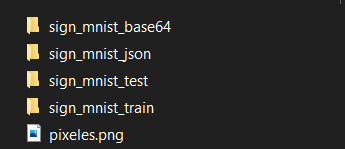
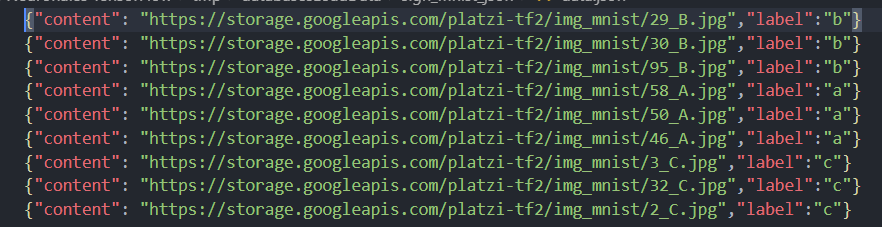

#### Deserialización de los datos

Para el procesamiento del dataset utilizaremos varios módulos de Python donde **JSON**, **codecs**, **requests** y **bytesIO** nos ayudarán en el proceso de peticiones mientras que el resto serán útiles para la manipulación y representación de las imágenes.

In [17]:
%pip install requests

     ---------------------------------------- 0.0/62.8 kB ? eta -:--:--
     ---------------------------------------  61.4/62.8 kB 1.1 MB/s eta 0:00:01
     -------------------------------------- 62.8/62.8 kB 674.1 kB/s eta 0:00:00
     ---------------------------------------- 0.0/140.9 kB ? eta -:--:--
     ----------------------------------- -- 133.1/140.9 kB 8.2 MB/s eta 0:00:01
     ----------------------------------- -- 133.1/140.9 kB 8.2 MB/s eta 0:00:01
     -------------------------------------- 140.9/140.9 kB 1.7 MB/s eta 0:00:00
     ---------------------------------------- 0.0/97.1 kB ? eta -:--:--
     ---------------------------------------- 97.1/97.1 kB 2.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
import json
import codecs
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

Determinamos la ubicación del dataset a cargar.

In [19]:
url = "tmp/databasesLoadData/sign_mnist_json/data.json"

Ahora crearemos un Array donde guardaremos los JSON; posteriormente abriremos el archivo, lo recorreremos línea a línea y lo guardaremos en un diccionario. Finalmente, verificaremos la cantidad de imágenes encontradas correlacionando el tamaño del array.

In [20]:
# Array donde guardaremos cada línea del diccionario que contiene la dirección de la imagen y su label
dataJSON = []

# Abrimos el archivo y lo leemos teniendo en cuenta la codificación UTF8; le creamos un alias para que sea más fácil llamarlo
with codecs.open(url, "r", "utf-8") as js:
    # Recorremos cada línea del archivo JSON
    for line in js:
        # Almacenamos la línea en la lista de los datos
        dataJSON.append(json.loads(line))
        
print(f"{len(dataJSON)} imágenes encontradas")
        

9 imágenes encontradas


Si verificamos el contenido de la lista nos encontraremos con un diccionario con las claves Content y Label.

In [21]:
dataJSON[0]

{'content': 'https://storage.googleapis.com/platzi-tf2/img_mnist/29_B.jpg',
 'label': 'b'}

Con los datos deserializados y aislados podemos descargar cada imagen por lo que haremos una petición HTTP, la encapsularemos en un objeto **BytesIO** el cual será interpretado como una imagen y finalmente lo transformaremos en un Array de **Numpy**.

In [22]:
# Lista de las imágenes
images = []

for data in dataJSON:
    # Hacemos un request a la dirección de cada imagen en GCP
    response = requests.get(data["content"])
    # El contenido que nos trajo el request lo encapsulamos, luego lo convertimos a una imagen y finalmente a un array de Numpy
    img = np.asarray(Image.open(BytesIO(response.content)))
    # Agregamos la imagen a la lista junto con su respectivo label
    images.append([img, data["label"]])

Por último, visualizaremos una imagen; para esto es necesario hacer un reshape al tamaño esperado (28x28).

La imagen es la letra b


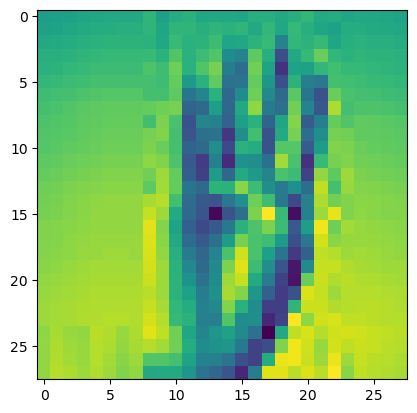

In [23]:
plt.imshow(images[0][0].reshape(28,28))
print(f"La imagen es la letra {images[0][1]}")

### Cargar bases de datos BASE64 

Para empezar, vemos que las imágenes en BASE64 se encontran codificadas. La estructura en la que están almacenadas es un diccionario con la codificación de la imagen.

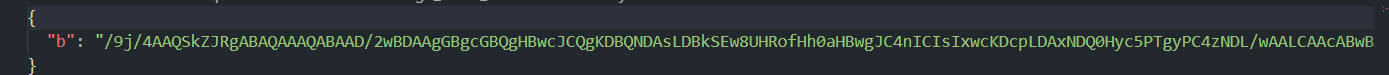

In [1]:
import base64

Definimos la ubicación del archivo a extraer la información.

In [2]:
url = "tmp/databasesLoadData/sign_mnist_base64/data.json"

Lo siguiente es cargar los datos del JSON a memoria.

In [6]:
with open(url) as file:
    data = json.load(file)

Cargamos los datos en una variable, determinamos la ubicación a guardar la imagen y abrimos un archivo al cual le pondremos el alias **fileToSave**; luego decodificamos el BASE64 y lo guardamos en un buffer para finalmente guardarlo en la ubicación.

In [7]:
# Guardar los datos codificados con UTF8
base64ImgBytes = data["b"].encode("utf-8")
# Ubicación a guardar la imagen
pathImg = "tmp/decodedImage.png"

# Abrimos el archivo 
with open(pathImg, "wb") as fileToSave:
    # Decodificamos la imagen de BASE64
    decodedImageData = base64.decodebytes(base64ImgBytes)
    # Guardamos la imagen
    fileToSave.write(decodedImageData)

Podemos utilizar la imagen abriéndola con PIL.

In [8]:
img = Image.open(pathImg)
img

### Cargando CSV

Utilizaremos **Pandas** para el manejo de CSV.

In [22]:
%pip install pandas seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
Note: you may need to restart the kernel to use updated packages.


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

Leemos los archivos CSV de training y testing.

In [13]:
train = pd.read_csv("tmp/databasesLoadData/sign_mnist_train/sign_mnist_train.csv")
test = pd.read_csv("tmp/databasesLoadData/sign_mnist_test/sign_mnist_test.csv")

Podemos analizar los primeros datos del dataset. La primera columna hace referencia al label de la imagen y el resto es el valor de cada pixel (28x28 = 784).

In [14]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


Separaremos la columna de labels del dataset y la guardaremos en una nueva variable.

In [16]:
labels = train["label"].values
train.drop("label", axis = 1, inplace = True)
labels

array([ 3,  6,  2, ..., 18, 17, 23], dtype=int64)

Finalmente, podemos graficar una imagen utilizando Matplotlib y haciendo un reshape para que sea de 28x28 pixeles.

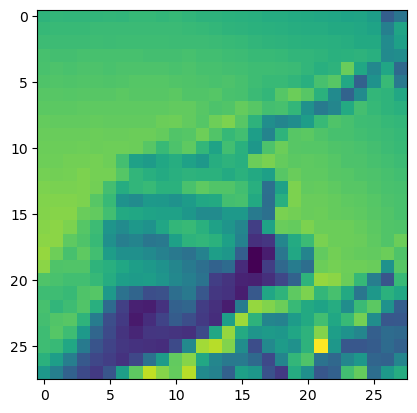

In [20]:
images = train.values
plt.imshow(images[1].reshape(28, 28))
plt.show()

### Preprocesamiento y limpieza de datos

El preprocesamiento de los datos es de las etapas más importantes en cualquier proyecto de Data Science ya que es un proceso altamente difícil de automatizar y requiere de creatividad e intelecto humano para hacerse correctamente. Es por ello que es necesario invertir el tiempo suficiente en realizar un buen preprocesamiento.

#### Carga y análisis exploratorio

En este caso utilizaremos una versión del dataset en CSV que contiene valores faltantes e incongruencias para ir solucionándolas.

In [21]:
train = pd.read_csv("tmp/databasesLoadData/sign_mnist_train/sign_mnist_train_clean.csv")

C:\Users\alexg\AppData\Local\Temp\ipykernel_10308\3782775195.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,25

In [25]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


Empezaremos entendiento la distribución de las etiquetas.

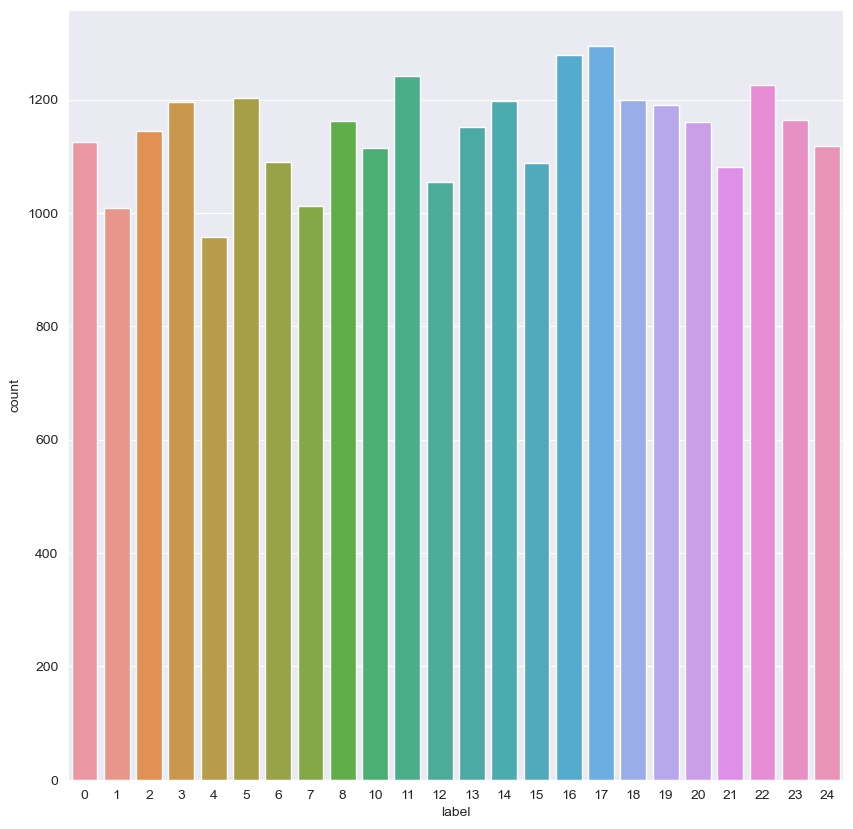

In [34]:
plt.figure(figsize = (10, 10))
sns.set_style("darkgrid")
sns.countplot(x = train["label"])
plt.show()

Vemos que, en general, el dataset se encuentra balanceado ya que cada etiqueta tiene entre 900 y 1200 ejemplos.

#### Limpieza de los datos

Lo primero será separar las etiquetas del dataset; bastará simplemente con aislar dicha columna en una nueva variable.

In [35]:
yTrain = train["label"]
yTest = test["label"]

XTrain = train.drop("label", axis = 1, inplace = True)
XTest = test.drop("label", axis = 1, inplace = True)

Para conocer las distintas etiquetas utilizamos la función **unique**

In [36]:
np.unique(np.array(labels))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

Verificamos que no tengamos valores nulos en el dataset.

In [40]:
train.isnull().values.any()

False

También verificamos que no hayan datos duplicados.

In [45]:
train.duplicated().value_counts()

False    27449
True         6
Name: count, dtype: int64

Borramos los registros duplicados.

In [49]:
train.loc[train.duplicated()]

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
487,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
689,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
802,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,...,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew
861,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,...,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew


In [51]:
train[train["pixel1"] == "fwefew"]

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
727,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,...,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew
802,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,...,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew
861,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,...,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew,fwefew


In [52]:
train.drop([317, 487, 595, 689, 802, 861, 727], axis = 0, inplace = True)

#### Preprocesamiento y optimización

Finalmente, normalizamos los datos para que sus valores estén entre 0 y 1 para que sea más fácil para el modelo trabajar con ellos.

In [53]:
# Nos aseguramos de que todos los datos sean numéricos
train = train.astype(str).astype(int)
train = train / 255
test = test / 255

train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.419608,0.462745,0.498039,0.525490,0.545098,0.560784,0.572549,0.588235,0.600000,0.611765,...,0.811765,0.811765,0.811765,0.811765,0.807843,0.807843,0.807843,0.800000,0.796078,0.792157
1,0.607843,0.615686,0.611765,0.611765,0.611765,0.615686,0.611765,0.619608,0.619608,0.615686,...,0.270588,0.584314,0.501961,0.341176,0.368627,0.639216,0.686275,0.403922,0.529412,0.584314
2,0.733333,0.737255,0.737255,0.733333,0.733333,0.729412,0.733333,0.737255,0.733333,0.729412,...,0.792157,0.788235,0.784314,0.780392,0.776471,0.780392,0.776471,0.764706,0.760784,0.764706
3,0.827451,0.827451,0.831373,0.831373,0.827451,0.823529,0.827451,0.823529,0.823529,0.827451,...,0.921569,0.917647,0.913725,0.905882,0.901961,0.886275,0.882353,0.870588,0.898039,0.639216
4,0.643137,0.654902,0.666667,0.674510,0.690196,0.701961,0.705882,0.721569,0.725490,0.729412,...,0.360784,0.411765,0.411765,0.423529,0.521569,0.639216,0.615686,0.639216,0.643137,0.701961


### Datasets Generator

En el momento en el que cargamos datos lo hacemos directamente a la memoria RAM por lo que si cargamos un dataset pesado de golpe es probable que terminemos colapsando el entorno de trabajo por una saturación de recursos.

Para evitar este problema se crean los generadores: una estructura que generará datos solo si es recorrida, optimizando así el uso de la memoria.

#### Descargando el dataset

Descargamos el dataset directamente desde GCP.

In [1]:
!wget --no-check-certificate https://storage.googleapis.com/platzi-tf2/sign-language-img.zip \
    -O tmp/sign-language-img.zip

--2023-04-03 20:02:37--  https://storage.googleapis.com/platzi-tf2/sign-language-img.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 173.194.210.128, 74.125.134.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24265584 (23M) [application/zip]
Saving to: 'tmp/sign-language-img.zip'

     0K .......... .......... .......... .......... ..........  0%  322K 73s
    50K .......... .......... .......... .......... ..........  0%  472K 62s
   100K .......... .......... .......... .......... ..........  0% 1,04M 48s
   150K .......... .......... .......... .......... ..........  0% 1,31M 41s
   200K .......... .......... .......... .......... ..........  1% 1,58M 35s
   250K .......... .......... .......... .......... ..........  1%  962K 33s
   300K .......... .......... .......... .......... ..........  1% 1,72M 30s
   350K .......... .......... ..

Descomprimimos el archivo.

In [2]:
import os 
import zipfile

# Dirección del archivo
localZip = "tmp/sign-language-img.zip"
# Leemos el archivo
zipRef = zipfile.ZipFile(localZip, "r")
# Lo descomprimimos en una carpeta con su mismo nombre
zipRef.extractall("tmp/sign-language-img")
# Cerramos la instancia
zipRef.close()

La estructura del dataset consta de dos directorios principales: Train y Test; en ellos hay una carpeta para cada clase con sus respectivos ejemplos.

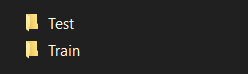
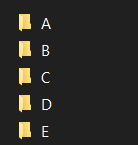
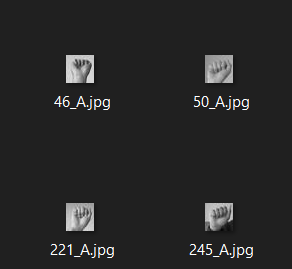

#### Cargando el dataset con Keras Generator

In [3]:
%pip install tensorflow

  Using cached tensorflow-2.12.0-cp39-cp39-win_amd64.whl (1.9 kB)
  Using cached tensorflow_intel-2.12.0-cp39-cp39-win_amd64.whl (272.8 MB)
  Using cached protobuf-4.22.1-cp39-cp39-win_amd64.whl (420 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached termcolor-2.2.0-py3-none-any.whl (6.6 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached wrapt-1.14.1-cp39-cp39-win_amd64.whl (35 kB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp39-cp39-win_amd64.whl (1.5 MB)
     ---------------------------------------- 0.0/5.6 MB ? eta -:--:--
      --------------------------------------- 0.1/5.6 MB 2.0 MB/s eta 0:00:03
     - -------------------------------------- 0.3/5.6 MB 3.2 MB/s eta 0:00:02
     --- ------------------------------------ 0.5/5.6 MB 4.3 MB/s eta 0:00:02
     ----- ---------------------------------- 0.8/5.6 MB 4.7 MB/s eta 0:00:02
     ------ ------------------------------

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Creamos unas variables para guardar las rutas de Training y Testing.

In [6]:
trainDir ="tmp/sign-language-img/Train"
testDir ="tmp/sign-language-img/Test"

Creamos los data generators aplicando un reescalado de los datos para que vayan de 0 a 1; además, dividiremos el 20% de los datos de testing para validation.

In [7]:
trainDataGen = ImageDataGenerator(rescale = 1/255)
testDataGen = ImageDataGenerator(rescale = 1/255, validation_split = 0.2)

Cargamos las imágenes a través del método **flow_from_directory** del generador. Determinamos el directorio fuente, el tamaño que tendrán las imágenes (si es necesario el generador las redimensionará), la cantidad de paquetes, el tipo de clases, el tipo de escala de colores y el subset al que pertenecen.

In [8]:
trainGenerator = trainDataGen.flow_from_directory(
    trainDir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "grayscale",
    subset = "training"
)

validationGenerator = testDataGen.flow_from_directory(
    testDir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "grayscale",
    subset = "validation"
)

testGenerator = testDataGen.flow_from_directory(
    testDir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "grayscale",
)

Found 27455 images belonging to 24 classes.
Found 1425 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


Para generar las clases simplemente haremos una lista recorriendo los caracteres ASCII omitiendo la J y la Z.

In [14]:
classes = [char for char in string.ascii_uppercase if char != "J" if char != "Z"]

Para graficar las imágenes crearemos una función que recibirá un array de imágenes y las mostrará en pantalla en grupos de 5.

In [11]:
def plotImages(images):
    fig, axes = plt.subplots(1, 5, figsize = (10, 10))
    axes = axes.flatten()
    
    for img, ax in zip(images, axes):
        ax.imshow(img[:, :, 0])
        ax.axis("off")
    
    plt.tight_layout()

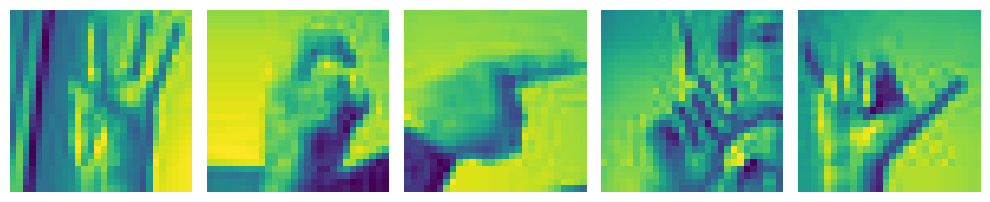

In [12]:
sampleTrainingImages, _ = next(trainGenerator)
plotImages(sampleTrainingImages[:5])

### Crear el modelo

Utilizaremos un modelo secuencial en el que apilaremos varias capas. La primera capa será la de entrada donde recibiremos una imagen de 28x28 pixeles en un solo canal, una vez recibida se aplana la imagen para ser procesada como un array unidimensional. Las siguientes dos capas serán de tipo Dense y contarán con 256 y 128 neuronas respectivamente, además de una función de activación ReLu. Finalmente, la capa de salida contará con 24 neuronas, una para cada posible clase, junto con una función de activación Softmax para retornar las probabilidades de cada letra.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

In [16]:
# Modelo secuencial base
modelBase = Sequential()

# Capa de entrada donde recibimos imágenes de 28x28 en un solo canal y aplanamos dicha imagen
modelBase.add(Flatten(input_shape = (28, 28, 1)))
# Apilamos una capa con 256 neuronas y una función de activación ReLu
modelBase.add(Dense(256, activation = "relu"))
# Apilamos una capa con 128 neuronas y una función de activación ReLu
modelBase.add(Dense(128, activation = "relu"))
# Capa de salida con 24 neuronas y función de activación Softmax
modelBase.add(Dense(len(classes), activation = "softmax"))

# Resumen del modelo
modelBase.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               200960    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 24)                3096      
                                                                 
Total params: 236,952
Trainable params: 236,952
Non-trainable params: 0
_________________________________________________________________


#### Compilar y entrenar el modelo

Compilaremos el modelo definiendo un optimizador, para este caso determinamos adam, un algoritmo que permite actualizar automáticamente el learning rate según el desempeño de la red. Como función de pérdida aplicaremos categorical cross entropy y la métrica de éxito será la precisión.

In [17]:
modelBase.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = "accuracy"
)

Entrenamos el modelo con el generador de imágenes, durante 20 épocas y utilizando los datos de validación.

In [18]:
history = modelBase.fit(
    trainGenerator,
    epochs = 20,
    validation_data = validationGenerator
)

Epoch 1/20
215/215 [==============================] - 145s 672ms/step - loss: 2.2415 - accuracy: 0.3424 - val_loss: 1.6697 - val_accuracy: 0.5095
Epoch 2/20
215/215 [==============================] - 11s 52ms/step - loss: 1.2717 - accuracy: 0.6080 - val_loss: 1.3382 - val_accuracy: 0.5768
Epoch 3/20
215/215 [==============================] - 11s 51ms/step - loss: 0.9264 - accuracy: 0.7161 - val_loss: 1.2537 - val_accuracy: 0.6056
Epoch 4/20
215/215 [==============================] - 11s 52ms/step - loss: 0.7004 - accuracy: 0.7893 - val_loss: 1.1715 - val_accuracy: 0.6414
Epoch 5/20
215/215 [==============================] - 11s 49ms/step - loss: 0.5374 - accuracy: 0.8396 - val_loss: 1.1092 - val_accuracy: 0.6596
Epoch 6/20
215/215 [==============================] - 10s 47ms/step - loss: 0.4050 - accuracy: 0.8862 - val_loss: 0.9803 - val_accuracy: 0.7018
Epoch 7/20
215/215 [==============================] - 10s 48ms/step - loss: 0.3153 - accuracy: 0.9124 - val_loss: 0.9918 - val_accurac

Observamos que el modelo obtuvo un Accuracy de 0.99 en training pero en validation obtuvo un 0.71

In [19]:
modelBase.evaluate(testGenerator)

57/57 [==============================] - 31s 550ms/step - loss: 1.1217 - accuracy: 0.7487


[1.1217362880706787, 0.7487451434135437]

Evaluando el modelo con los datos de testing encontramos un Accuracy de 0.75 mientras que en el entrenamiento era casi absoluta.

#### Evaluación del modelo

In [13]:
def visualizacionResultados(history):
  epochs = [i for i in range(20)]
  fig, ax = plt.subplots(1, 2)
  trainAcc = history.history["accuracy"]
  trainLoss = history.history["loss"]
  valAcc = history.history["val_accuracy"]
  valLoss = history.history["val_loss"]
  fig.set_size_inches(16, 9)

  ax[0].plot(epochs, trainAcc, "go-", label = "Training Accuracy")
  ax[0].plot(epochs, valAcc, "ro-", label = "Validation accuracy")
  ax[0].set_title("Training and Validation Accuracy")
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(epochs, trainLoss, "go-", label = "Training Loss")
  ax[1].plot(epochs, valLoss, "ro-", label = "Validation Loss")
  ax[1].set_title("Training and Validation Loss")
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")

  plt.show()

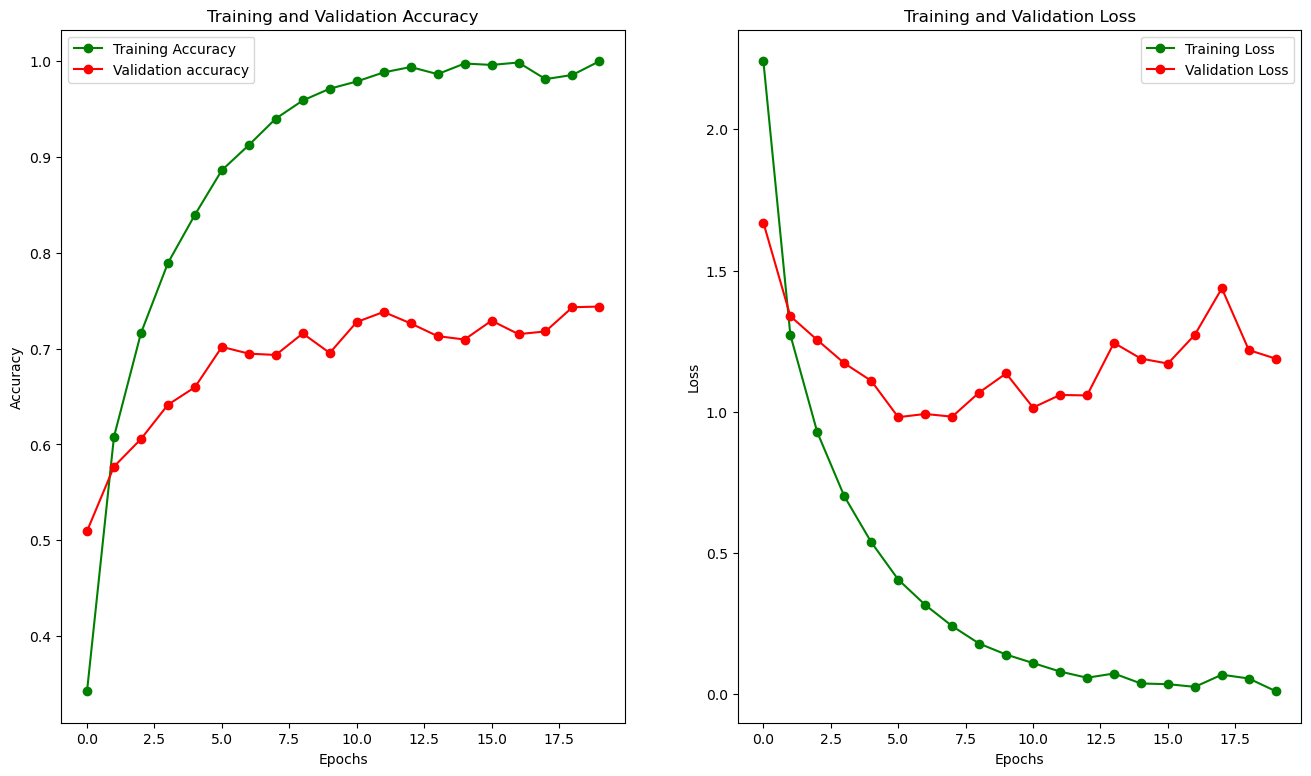

In [22]:
visualizacionResultados(history)

Podemos observar una diferencia abrupta en el Accuracy de training y validation lo cual es una señal de overfitting.

### Distribución de los datos

Los datos que poseemos son finitos y debemos distribuirlos para que el entrenamiento se haga con la mayor cantidad de ejemplos posibles a la vez que podemos verificar la veracidad del modelo con datos reales que este no haya visto anteriormente; es por esto que se crean los subsets de training, validation y testing.

La distribución de los datos en los diferentes subsets se puede determinar de diferentes maneras, donde la configuración promedio será de 70% para training y 30% para testing. Andrew NG propone una estructura de 60% para training, 20% para validation y 20% para testing. Si se tienen muchos datos entonces se puede maximizar la cantidad de datos a training con uns estructura 90% / 5% / 5%. Por otro lado, si se cuentan con pocos datos entonces es recomendable aplicar la técnica de Cross Validation para iterar el subset de validation entre los datos de training.

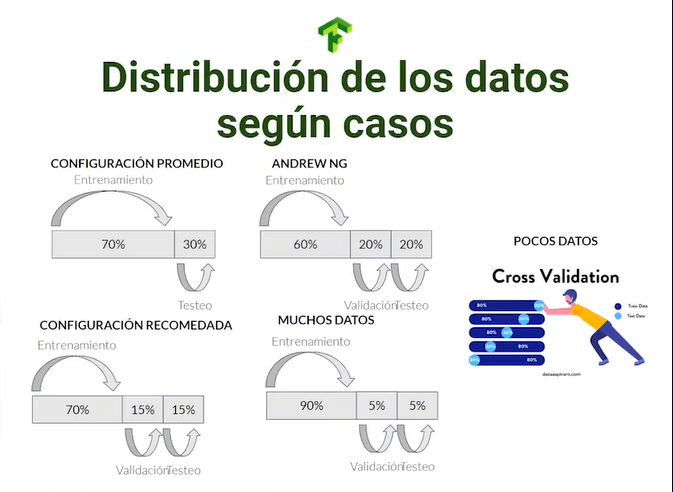

Un error común es el de combinar erróneamente los datos de training con los de testing lo cual resulta en un rendimiento artificialmente alto para la red debido al Overfittig.

Otro error es el de tener bases de datos con clases desbalanceadas en él, es decir, la cantidad de ejemplos entre diferentes clases es muy diferente.

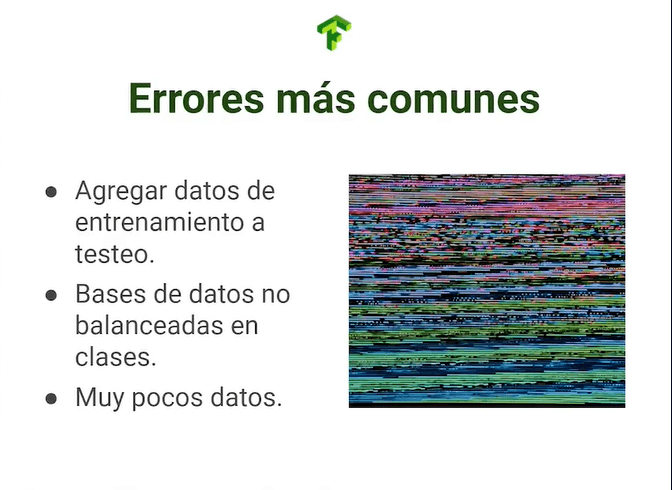

## Optimización de modelos

### Regularizadores

La principal fuente de optimización de un modelo de Deep Learning se da mediante los regularizadores: técnicas que se usan para mejorar matemáticamente la convergencia de los datos y evitar atascamientos como el Overfitting y el Underfitting. Los regularizadores más importantes son Callbacks y Regularizadores L1 (Lasso) y L2 (Ridge).

#### Dropout

Es una técnica que apaga un porcentaje aleatorio de neuronas por cada iteración, obligando a aquellas activas a comprender un patrón general en vez de memorizar la estructura de los datos.

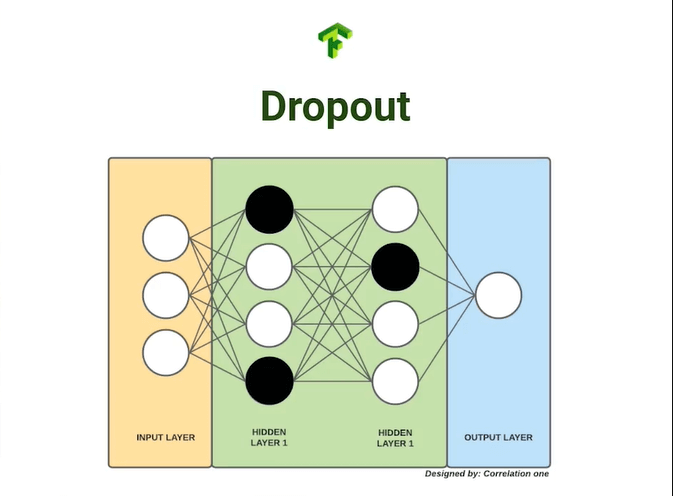

#### Regularizadores L1 y L2

Los regularizadores son modificadores a las matrices de pesos que permiten ajustar sus valores y penalizar aquellos datos matemáticamente extremos.

El regularizador Lasso L1 se usa cuando se sospecha que pueden haber datos de entrada que son irrelevantes para la red; su uso reducirá la cantidad de features innecesarias, haciendo que el modelo sea más puro.

El regularizador Ridge L2 se usa cuando los datos de entrada se encuentran altamente correlacionados entre ellos, lo que aumenta la desviación; su uso reducirá uniformemente la magnitud de los features, armonizando el crecimiento de la red.

La combinación de estos dos regularizadores se conoce como ElasticNet, que será de utilidad en el manejo de modelos complejos con altas cantidades de features.

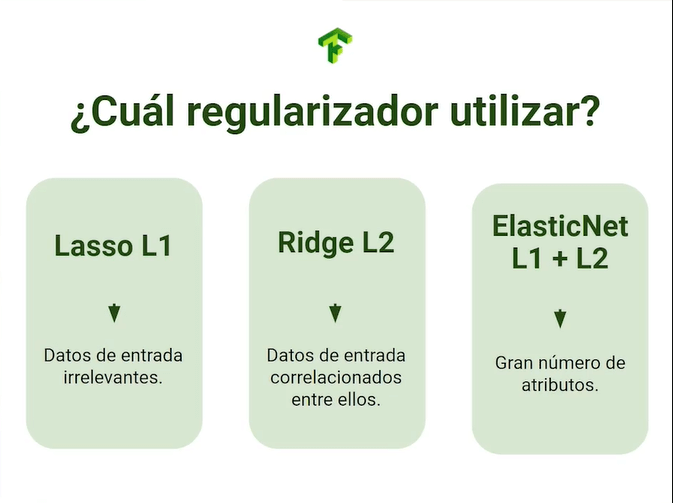

### Utilizando regularizadores

Los regularizadores L1 y L2 se encuentran en el módulo **regularizers** de **Keras** y Dropout se encuentra en el módulo de **layers**.

In [3]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

Ahora definiremos una nueva arquitectura basada en la anterior pero aplicando una serie de cambios que impactarán en el desempeño de la red.

En las capas ocultas añadiremos el parámetro *kernel_regularizer* que utilizará el regularizador L2 con un valor de 1e-5; adicionalmente, después de cada capa oculta añadiremos una de dropout con una desactivación del 20% de las neuronas por iteración.

In [10]:
# Creación del modelo secuencial
modelOptimizer = Sequential()

# Capa de entrada donde recibimos imágenes de 28x28 en un solo canal y aplanamos dicha imagen
modelOptimizer.add(Flatten(input_shape = (28, 28, 1)))
# Apilamos una capa con 256 neuronas, regularización Ridge y una función de activación ReLu
modelOptimizer.add(Dense(256, kernel_regularizer = regularizers.l2(1e-5), activation = "relu"))
# Añadimos una capa de dropout con probabilidad de 0.2
modelOptimizer.add(Dropout(0.2))
# Apilamos una capa con 128 neuronas, regularización Ridge y una función de activación ReLu
modelOptimizer.add(Dense(128, kernel_regularizer = regularizers.l2(1e-5), activation = "relu"))
# Añadimos una capa de dropout con probabilidad de 0.2
modelOptimizer.add(Dropout(0.2))
# Capa de salida con 24 neuronas y función de activación Softmax
modelOptimizer.add(Dense(len(classes), activation = "softmax"))

# Resumen del modelo
modelOptimizer.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               200960    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 24)                3096      
                                                                 
Total params: 236,952
Trainable params: 236,952
Non-tr

Ahora compilamos y entrenamos el modelo.

In [11]:
modelOptimizer.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = "accuracy"
)

In [12]:
historyOptimizer = modelOptimizer.fit(
    trainGenerator,
    epochs = 20,
    validation_data = validationGenerator
)

Epoch 1/20
215/215 [==============================] - 159s 732ms/step - loss: 2.5589 - accuracy: 0.2260 - val_loss: 1.8251 - val_accuracy: 0.4428
Epoch 2/20
215/215 [==============================] - 11s 49ms/step - loss: 1.6128 - accuracy: 0.4713 - val_loss: 1.4214 - val_accuracy: 0.5368
Epoch 3/20
215/215 [==============================] - 11s 53ms/step - loss: 1.2467 - accuracy: 0.5852 - val_loss: 1.2101 - val_accuracy: 0.6105
Epoch 4/20
215/215 [==============================] - 11s 53ms/step - loss: 0.9985 - accuracy: 0.6656 - val_loss: 1.0572 - val_accuracy: 0.6779
Epoch 5/20
215/215 [==============================] - 11s 53ms/step - loss: 0.8502 - accuracy: 0.7151 - val_loss: 0.9887 - val_accuracy: 0.6982
Epoch 6/20
215/215 [==============================] - 12s 56ms/step - loss: 0.7360 - accuracy: 0.7531 - val_loss: 0.9255 - val_accuracy: 0.7109
Epoch 7/20
215/215 [==============================] - 12s 55ms/step - loss: 0.6369 - accuracy: 0.7867 - val_loss: 0.8853 - val_accurac

Podemos notar que si bien la precisión de entrenamiento disminuyó, la precisión de validación aumentó.

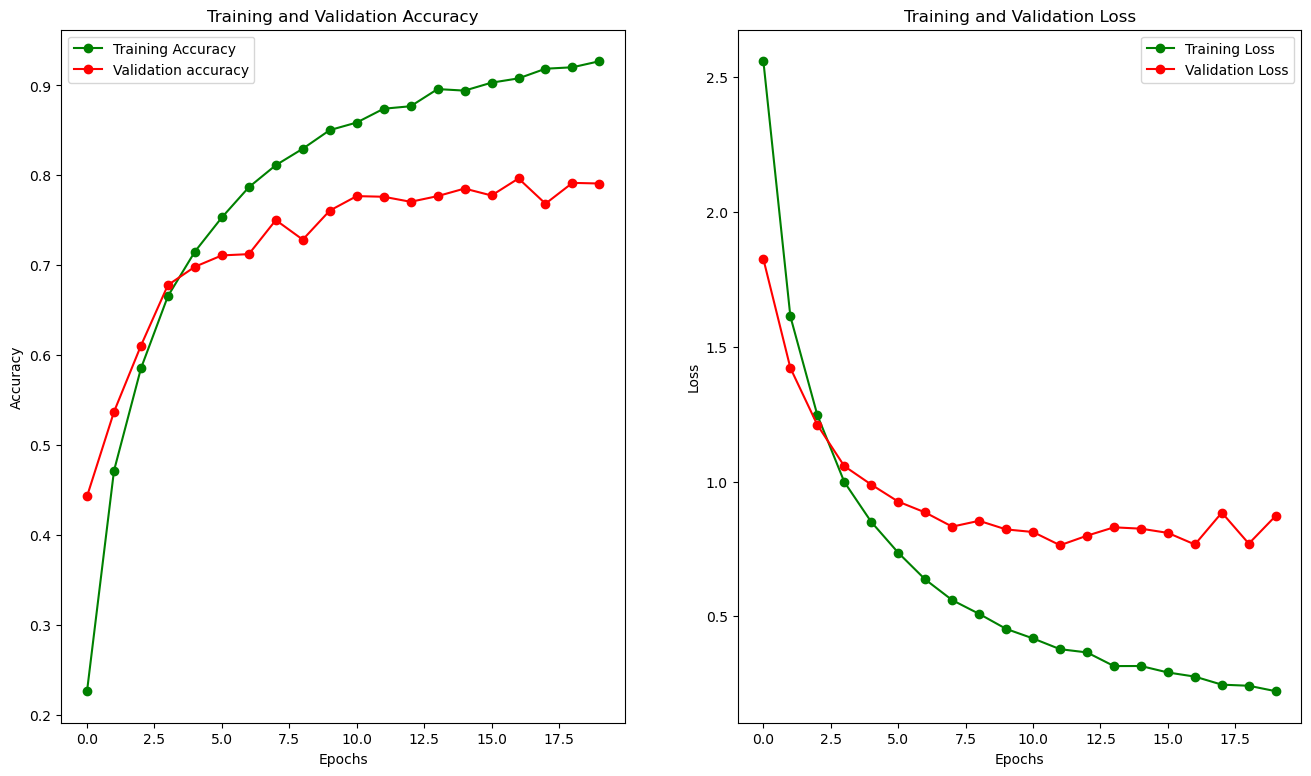

In [14]:
visualizacionResultados(historyOptimizer)

### Recomendaciones para ajustar un modelo

#### Durante el preprocesamiento de los datos

En esta etapa temprana es de vital importancia entender la naturaleza de los datos y sus propósitos. Algunas recomendaciones son:
- Buscar datos nulos o archivos corruptos: estos datos aportarán basura al modelo y reducirán el rendimiento final si no son excluidos del dataset prematuramente.
- Balancer el dataset: es importante que la cantidad de ejemplos para cada clase sea proporcional ya que un desbalanceo terminará en un algoritmo que no clasificará correctamente pero (falsamente) dará buenas métricas.
- Aplicar normalización: normalizar los datos hará que sean más livianos de procesar y que se estandaricen frente al resto de features.
- Visualizar y entender los datos: la lógica del negocio lo es todo; si logramos entender la naturaleza y el propósito de nuestros datos, podremos dar una dirección diferente a nuestros proyectos y aumentar nuestro valor.

#### Ajuste de hiperparámetros

Estas configuraciones se hacen durante la creación de la arquitectura y la compilación del modelo y son más específicas con respecto a valores numéricos. Algunas recomendaciones son:
- Crear convoluciones de tamaño 3x3, de esta manera no perderemos información durante las operaciones.
- Definir capas de MaxPooling de 2x2 para reducir la complejidad del modelo y no perder abruptamente features por cada convolución.
- Aplanar las imágenes solo al final del proceso para combinar todos los features obtenidos de las convoluciones en un solo array unidimensional.
- Inicialzar nuestros modelos con arquitecturas pequeñas, de pocas neuronas. Empezar desde 32 o 64 neuronas y crecer la cantidad por cada capa según las potencias de 2 (64, 128, 256, 512).
- Inicializar el Learning Rate en 0.001, los regularizadores L1 y L2 en 1e-5 y el Dropout en 0.2 (20%).

#### Regularizadores

Los regularizadores son un tipo de hiperparámetros que tienen sus propias intuiciones. Algunas recomendaciones son:
- Determinar qué tipo de regularizador usar según la naturaleza de los datos. Si creemos que pueden haber features inútiles en la red, entonces aplicamos L1; si creemos que tenemos features correlacionadas entre sí, entonces aplicamos L2; si tenemos un dataset con gran cantidad de datos y ambas situaciones aplican, utilizamos ElasticNet.
- Si la red no está rindiendo lo suficiente entonces hay que intentar agregar más datos a partir de la fuente original; si no es posible, podemos generar nuevos datos utilizando Data Augmentation.
- Siempre es buena idea agregar Dropout ya que obligará al modelo a generalizar patrones en lugar de memorizar ejemplos.
- Podemos controlar el rendimiento de la red con Callbacks, específicamente el de Early Stopping, el cual detendrá el entrenamiento si no se detecta una mejoría respecto a una métrica después de ciertas iteraciones; o el de Model Checkpoint, el cual guardará una instancia con los pesos del modelo en su mejor época.

#### Funciones de activación

- Si debemos clasificar entre más de dos clases, entonces usamos la función Softmax.
- Si la clasificación es binaria, entonces usamos la función Sigmoide.
- Para regresión lo mejor es usar una función lineal (en ocasiones es mejor no aplicar función de activación en la capa final).
- Si tenemos más de 0 clases, siempre será óptimo usar ReLu durante el uso de las capas ocultas.

#### Durante la configuración de la red

- Siempre utilizar capas de Convolución y MaxPooling de ser posible.
- Variar y buscar el Learning Rate óptimo para el modelo ya que es posible aplicar valores muy altos y que el modelo no alcance el mínimo global, o caplicar valores muy bajos y que tome demasiadas iteraciones sacar conclusiones.
- Siempre almacenar el registro de entrenamientos. Es posible que durante alguna iteración del entrenamiento encontremos una configuración que dio un excelente desempeño pero al no guardar los datos la perdimos y debemos volver a empezar.

### Ajustando el modelo

En este modelo agregaremos una capa de convolución con 75 filtros de tamaño 3x3 y con función de activación ReLU; además, por ser la primera capa, recibirá las dimensiones de los datos de entrada.

Para reducir un poco la complejidad del modelo usaremos una capa de MaxPooling de 2x2 que abstraerá el pixel más relevante por cada 4 pixeles, mitigando el tamaño de salidas que generarán las convoluciones.

Finalmente aplanaremos las imágenes para procesarlas como lo estábamos haciendo en el modelo original.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [15]:
# Creación del modelo secuencial
modelConvolutional = Sequential()

# Capa de entrada convolucional con 75 filtros de 3x3, activación ReLu y especificamos el tamaño de las imágenes de entrada
modelConvolutional.add(Conv2D(75, (3, 3), activation = "relu", input_shape = (28, 28, 1)))
# Añadimos una capa de MaxPooling de tamaño 2x2
modelConvolutional.add(MaxPooling2D(pool_size = (2, 2)))
# Aplanamos los datos para que queden en un array unidimensional
modelConvolutional.add(Flatten())
# Apilamos una capa con 64 neuronas, regularización Ridge y una función de activación ReLu
modelConvolutional.add(Dense(64, kernel_regularizer = regularizers.l2(1e-5), activation = "relu"))
# Añadimos una capa de dropout con probabilidad de 0.2
modelConvolutional.add(Dropout(0.2))
# Apilamos una capa con 128 neuronas, regularización Ridge y una función de activación ReLu
modelConvolutional.add(Dense(128, kernel_regularizer = regularizers.l2(1e-5), activation = "relu"))
# Añadimos una capa de dropout con probabilidad de 0.2
modelConvolutional.add(Dropout(0.2))
# Capa de salida con 24 neuronas y función de activación Softmax
modelConvolutional.add(Dense(len(classes), activation = "softmax"))

# Resumen del modelo
modelConvolutional.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 75)        750       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 75)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 12675)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                811264    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                      

Compilamos el modelo.

In [17]:
modelConvolutional.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = "accuracy"
)

### Early Stopping y Model Checkpoint

Utilizaremos un Callback de Early Stopping y uno de Model Checkpoint. 

El de Early Stopping vigilará la métrica de Loss, tendrá una paciencia de 5, es decir, si en 5 épocas la pérdida no baja entonces se terminará el entrenamiento; el modo lo estará en automático para que determine él mismo si buscamos la reducción o aumento de la métrica.

El de Model Checkpoint guardará los pesos del modelo que haya tenido un mejor desempeño en la métrica de Loss en un archivo llamado modelConvolutional.hdf5

In [1]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [19]:
checkpoint = ModelCheckpoint(
    # Nombre del archivo. La extensión hdf5 es usada para guardar los pesos del modelo
    filepath = "modelConvolutional.hdf5",
    verbose = 1,
    # Métrica que queremos monitorear
    monitor = "loss",
    # Solo guardar los pesos del mejor modelo
    save_best_only = True
)

early = EarlyStopping(
    # Métrica que monitoreamos para ver si deja de mejorar
    monitor = "loss",
    # Número de iteraciones que espera para ver si la métrica no mejora
    patience = 5,
    mode = "auto"
)

### Entrenar el modelo

Con todas estas modificaciones entonces procedemos a entrenar el modelo.

In [20]:
historyConvolutional = modelConvolutional.fit(
    trainGenerator,
    epochs = 20,
    callbacks = [early, checkpoint],
    validation_data = validationGenerator
)

Epoch 1/20
215/215 [==============================] - ETA: 0s - loss: 2.2008 - accuracy: 0.3092
Epoch 1: loss improved from inf to 2.20076, saving model to modelConvolutional.hdf5
215/215 [==============================] - 161s 741ms/step - loss: 2.2008 - accuracy: 0.3092 - val_loss: 1.2139 - val_accuracy: 0.6407
Epoch 2/20
215/215 [==============================] - ETA: 0s - loss: 0.9529 - accuracy: 0.6779
Epoch 2: loss improved from 2.20076 to 0.95286, saving model to modelConvolutional.hdf5
215/215 [==============================] - 20s 94ms/step - loss: 0.9529 - accuracy: 0.6779 - val_loss: 0.7876 - val_accuracy: 0.7453
Epoch 3/20
215/215 [==============================] - ETA: 0s - loss: 0.5799 - accuracy: 0.8080
Epoch 3: loss improved from 0.95286 to 0.57993, saving model to modelConvolutional.hdf5
215/215 [==============================] - 21s 98ms/step - loss: 0.5799 - accuracy: 0.8080 - val_loss: 0.7104 - val_accuracy: 0.7649
Epoch 4/20
215/215 [==============================]

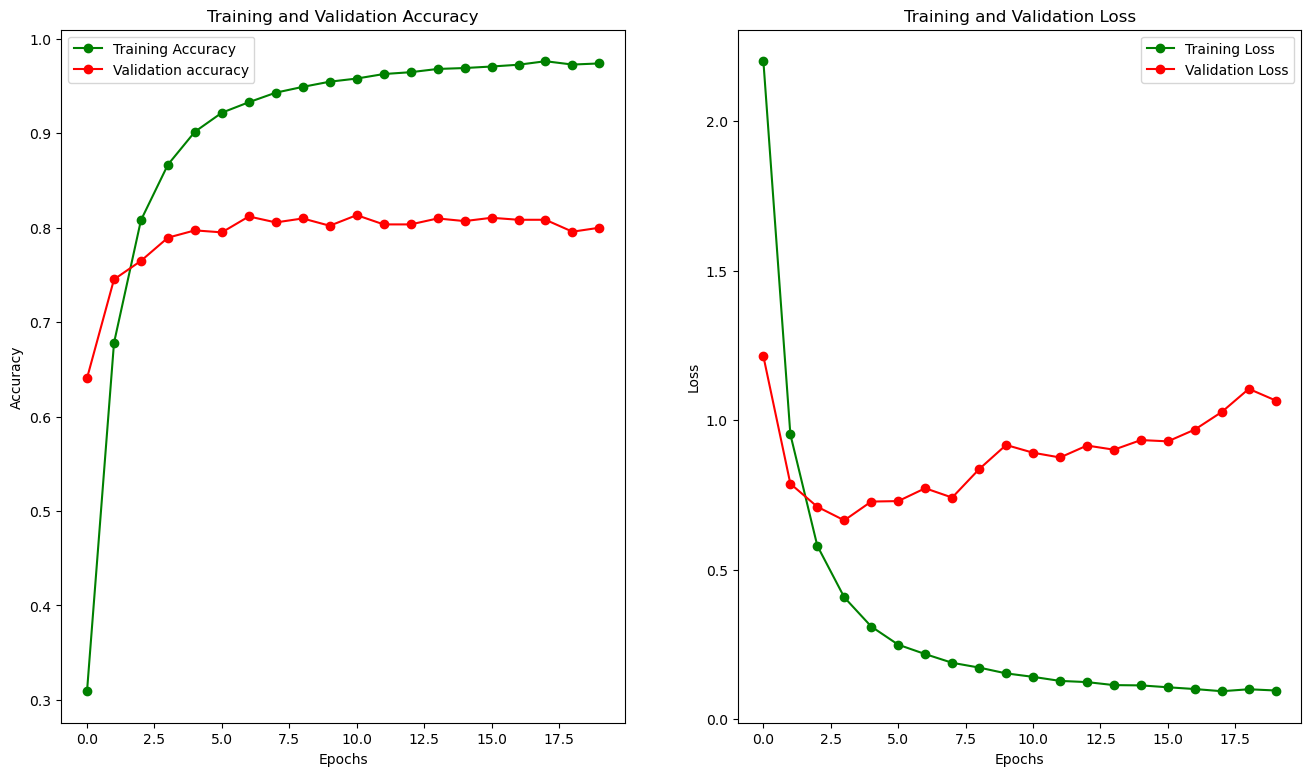

In [21]:
visualizacionResultados(historyConvolutional)

In [16]:
modelConvolutional.load_weights("modelConvolutional.hdf5")

### KerasTuner

El autotuner de Keras nos permitirá automatizar el proceso de configuración de nuestra red neuronal.

Cuando deseemos iterar sobre múltiples configuraciones para el modelo (probar diferentes capas, neuronas, épocas, learning rate y demás) no tendremos que hacerlo manualmente modelo a modelo ya que esta herramienta nos permitirá cargar y ejecutar diferentes fórmulas para comparar sus rendimientos.

In [19]:
%pip install -q -U keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [21]:
import keras_tuner as kt
from tensorflow import keras

Crearemos un nuevo constructor de modelos el cual recibirá como parámetros un objeto Tuner que determinará las variaciones de diferentes hiperparámetros.

Definiremos una arquitectura general donde agregaremos una capa de convolución, Max Pooling y aplanamiento de manera fija; luego, determinaremos la primera variable del constructor: la cantidad de neuronas en la siguiente capa oculta, se inicializará en 32 e incrementará hasta 512 dando saltos de 32 en 32.

La cantidad de neuronas de la siguiente capa será el objeto iterador. El resto de la red se mantendrá estable.

Finalmente, definiremos variaciones en el learning rate, donde empezaremos el modelo con 3 posibles learning rate: 0.01, 0.001 y 0.0001.

Al momento de compilar el modelo definiremos Adam como optimizador; sin embargo, llamaremos directamente a la clase y le entregaremos el objeto iterador. 

In [22]:
def constructorModelos(hp):
    # Creamos un modelo secuencial
    model = Sequential()
    # Añadimos una capa de convolución de 75 filtros de 3x3; activación ReLu y la forma de los datos de entrada de 28x28x1
    model.add(Conv2D(75, (3, 3), activation = "relu", input_shape = (28, 28, 1)))
    # Apilamos una capa de MaxPooling de 2x2
    model.add(MaxPooling2D((2,2)))
    # Aplanamos los datos para que queden en un array unidimensional
    model.add(Flatten())

    # Definimos el rango de neuronas por el que iterará la capa; empezamos en 32 y con saltos de 32 avanzamos hasta 512
    hpUnits = hp.Int("units", min_value = 32, max_value = 512, step = 32)
    # Capa densa que cambiará su número de neuronas
    model.add(Dense(units = hpUnits, activation = "relu", kernel_regularizer = regularizers.l2(1e-5)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation = "relu", kernel_regularizer = regularizers.l2(1e-5)))
    model.add(Dropout(0.2))
    model.add(Dense(len(classes), activation = "softmax"))

    # Definimos los distintos valores de Learning Rate con el que probará el modelo
    hpLearningRate = hp.Choice("learning_rate", values = [1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = hpLearningRate), 
        loss = "categorical_crossentropy", 
        metrics = ["accuracy"]
    )

    return model

Con el generador de modelos definido podremos crear el tuner que iterará a través de la configuración definida.

Crearemos una instancia Hyperband, que será el objeto que iterará en las configuraciones; su primer parámetro será la función constructora de modelos, luego la métrica objetivo (usaremos val_accuracy para medir la precisión real del modelo), el número máximo de épocas, un factor, un directorio de carga y un nombre del proyecto.

In [25]:
tuner = kt.Hyperband(
    constructorModelos,
    objective = "val_accuracy",
    max_epochs = 20,
    factor = 3,
    directory = "models/",
    project_name = "sign_tunner"
)

Con un tuner generado podremos empezar la búsqueda. Al método **search** le entregaremos el dataset, el número de épocas y los datos de validación.
Guardaremos la configuración con mejor desempeño.

In [26]:
tuner.search(trainGenerator, epochs = 20, validation_data = validationGenerator)

bestHps = tuner.get_best_hyperparameters(num_trials = 1)[0]

NameError: name 'trainGenerator' is not defined

Para obtener las mejores configuraciones utilizaremos el método **get**

In [27]:
print(f"La mejor cantidad de neuronas fue {bestHps.get("units")} \nEl mejor Learning Rate fue {bestHps.get("learning_rate")}")

SyntaxError: f-string: unmatched '(' (1524647654.py, line 1)

Con los mejores hiperparámetros encontrados podemos construir un modelo optimizado utilizando el método **hypermodel.build** el cual recibirá la configuración como argumento.

In [ ]:
hypermodel = tuner.hypermodel.build(bestHps)

historyHypermodel = hypermodel.fit(
    trainGenerator,
    epochs = 20,
    callbacks = [early, checkpoint],
    validation_data = validationGenerator
)

## Almacenamiento y carga de modelos

Aunque logremos entrenar la mejor arquitectura de todas y encontrar los mejores parámetros posibles, si cerramos el notebook, perderemos todo el progreso. 

Los modelos tienen 3 componentes principales: la arquitectura (que define la cantidad de capas, neuronas y entradas de la red), los pesos (que son los valores que se entrenan a la red) y las etiquetas (estas se usan especialmente en transfer learning para dar contexto al modelo).

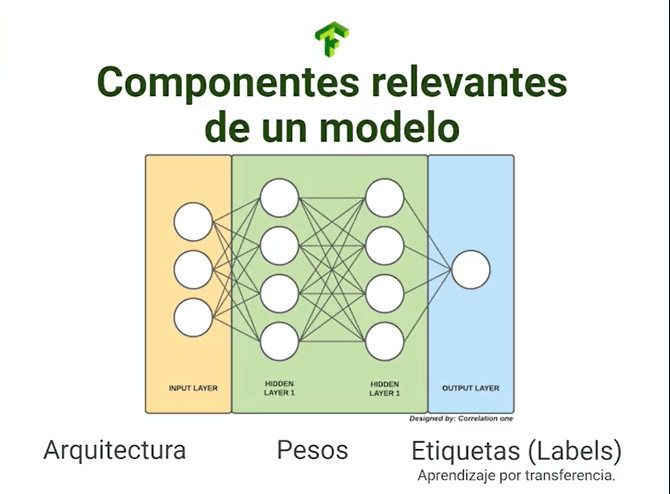

### Cargando y descargando arquitecturas sin pesos

Podemos usar la arquitectura de un modelo para basarnos en ella a la hora de entrenar otros modelos; esto no traerá los pesos, por lo que no será útil para realizar predicciones.

Con el método **get_config** de los modelos, podemos adquirir un JSON completo con la información de la arquitectura de la red.

In [ ]:
configDict = hypermodel.get_config()

Para cargar un modelo con base en esta configuración bastará con usar el método **from_config** de los modelos secuenciales de Keras enviando como parámetro el JSON de configuración.

In [ ]:
modelSameConfig = Sequential.from_config(configDict)
modelSameConfig.summary()

### Descargando arquitecturas con pesos

Para guardar arquitecturas con pesos es necesario usar el callback de **ModelCheckpoint** que nos permitirá guardar en disco el modelo con sus pesos.

In [ ]:
checkpoint = ModelCheckpoint(
    # Nombre del archivo
    filepath = "modelCheckpoint.h5",
    verbose = 1,
    # Métrica que queremos monitorear
    monitor = "val_accuracy",
    # Cada época revisa el modelo
    frecuency = "epoch",
    # Guardar solo los pesos
    save_weights_only = True,
)

Y al momento de entrenar el modelo agregamos este callback.

### Cargando arquitecturas con pesos

Para cargar un modelo desde disco basta con utilizar el método **load_weights** la ubicación del archivo que anteriormente guardó los pesos gracias al Checkpoint.

In [ ]:
# Crear un modelo y luego compilarlo; luego cargamos los pesos

model.load_weights()

### Criterios para almacenar modelos

En la práctica la carga de modelos no sucede de manera atómica (no se cargan solo los pesos o solo la arquitectura) sino que se hace todo a la vez. Tampoco se almacenan todos los modelos, únicamente guardamos los mejores desempeños. Esto lo logramos cambiando un poco nuestro Checkpoint.

In [ ]:
checkpoint = ModelCheckpoint(
    # Nombre del archivo
    filepath = "bestModelCheckpoint.h5",
    # Cada época revisa el modelo
    frecuency = "epoch",
    # Guardar todo el modelo
    save_weights_only = False,
    verbose = 1,
    # Métrica que queremos monitorear
    monitor = "val_accuracy",
    # Solo guardar el mejor modelo pesos
    save_best_only = True
)

Podemos guardar el modelo de forma manual con el método **save** de un modelo.

In [ ]:
model.save("savedModelComplete")

Para cargar un modelo utilizamos la función **load_model** pasando la ubicación.

In [ ]:
model = tf.keras.models.load_model("savedModelComplete")

## Resultados de entrenamiento

### TensorBoard

TensorBoard es una herramienta de TensorFlow creada para la visualización de resultados, que nos permite ver de manera gráfica la composición, estructura, variables relevantes y demás insights de nuestro modelo y nos ofrece la oportunidad de debuggearlo para obtener las mejores configuraciones posibles.

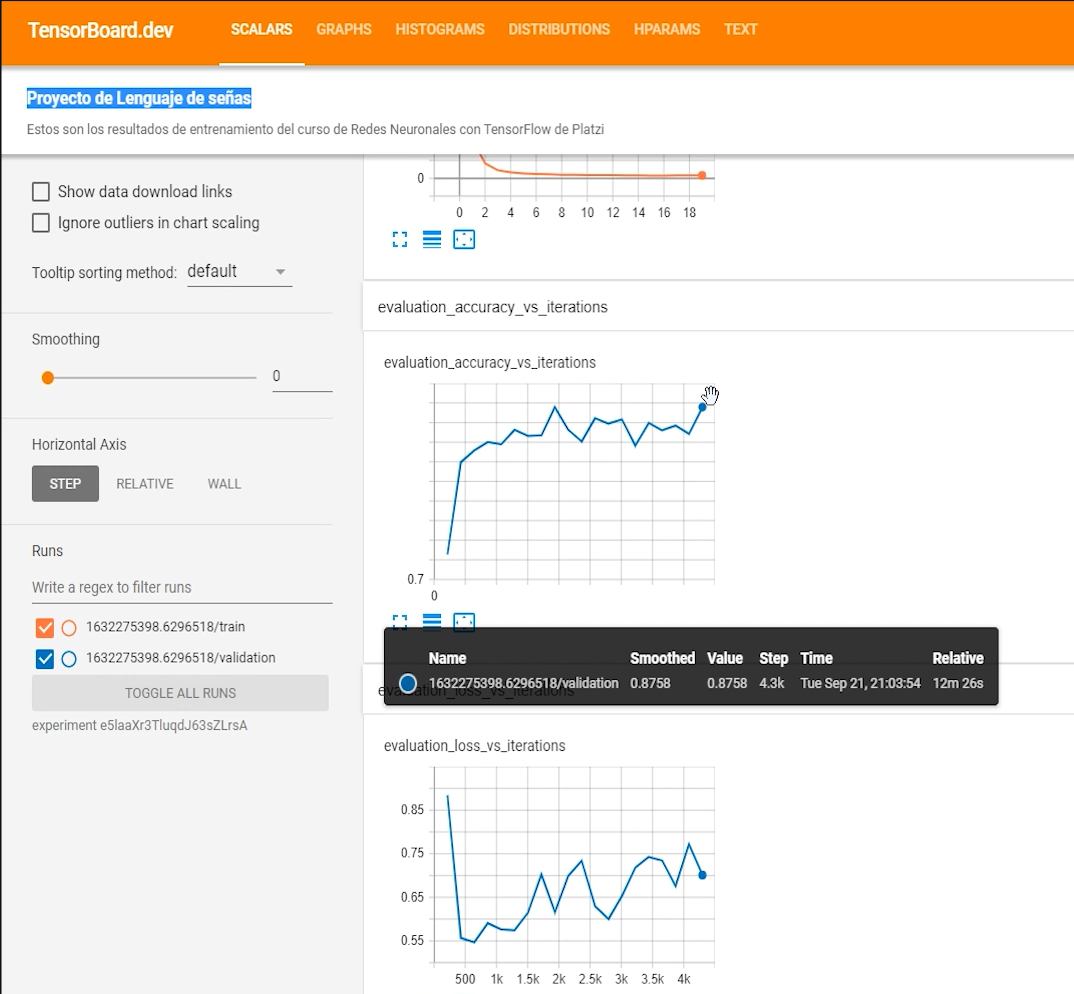
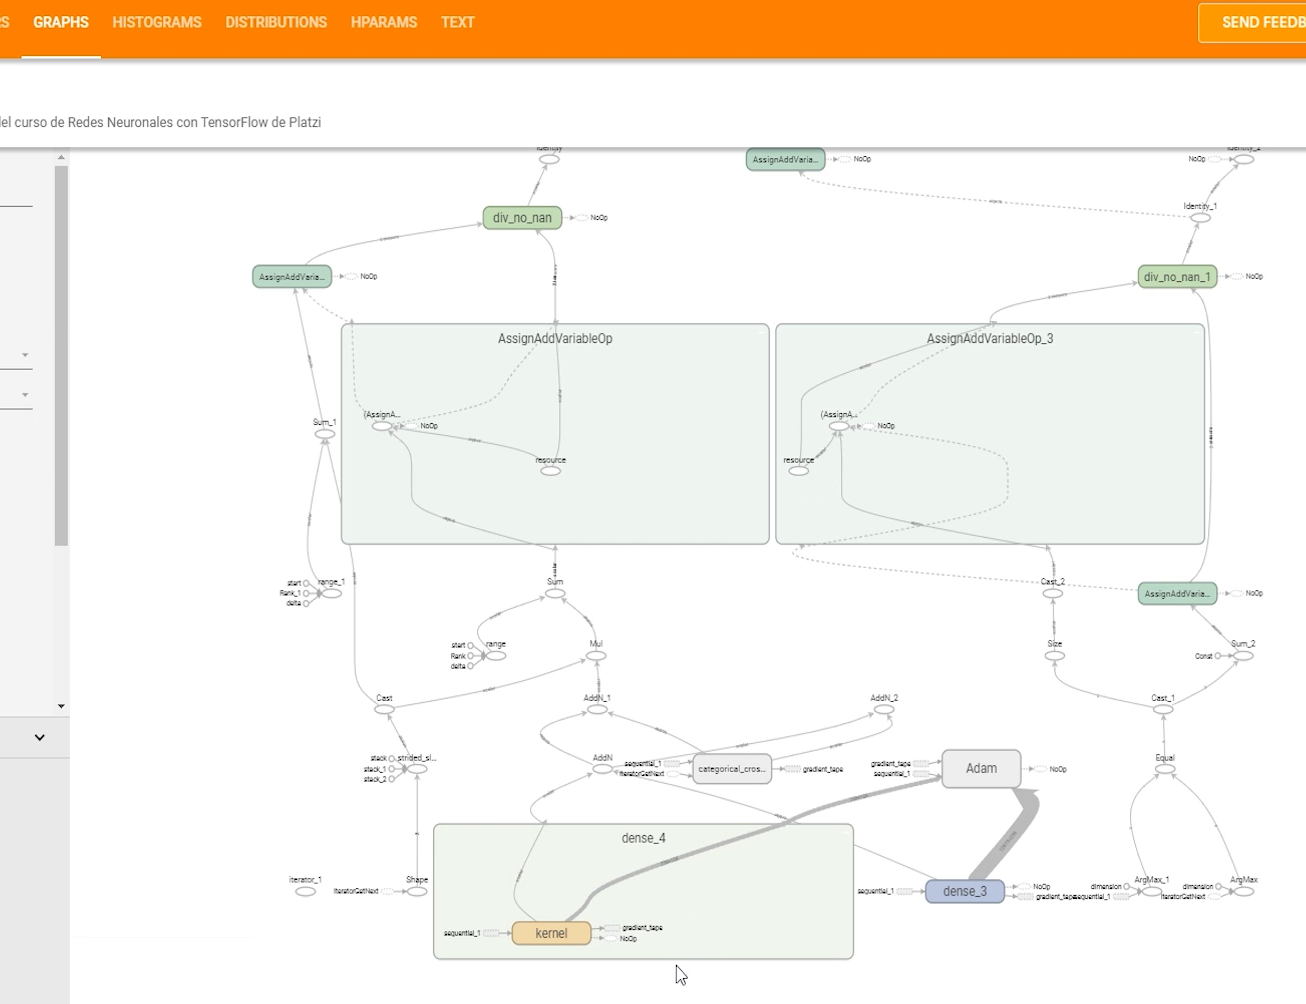

Para trabajar con el TensorBoard lo hacemos a través de un Callback con su mismo nombre.

In [1]:
from tensorflow.python.keras.callbacks import TensorBoard
from time import time

In [ ]:
modelTensorboard = constructorModelos()
modelTensorboard.compile(
    optimizer = "adam", 
    loss = "categorical_crossentropy", 
    metrics = ["accuracy"]
)

Antes de entrenar el modelo crearemos el callback de TensorBoard al que le especificaremos la ruta donde deberá guardar los registros.

In [ ]:
callbackTensorboard = TensorBoard(log_dir = f"logs/{time()}")

Entrenaremos el modelo agregando el TensorBoard como callback.

In [ ]:
historyTensorboard = modelTensorboard.fit(
    trainGenerator,
    epochs = 20,
    callbacks = [callbackTensorboard],
    validation_data = validationGenerator
)

Ahora emplearemos los comandos mágicos de IPython para cargar TensorBoard. Una vez cargado, le indicaremos el directorio del que debe extraer los resultados para analizarlos.

In [ ]:
%load_ext tensorboard

%tensorboard --logdir logs

Si queremos desplegar los resultados a la web, TensorBoard ofrece el comando **upload**, al que le pasaremos la dirección de los logs, el nombre del proyecto y la descripción. Después de una breve configuración y autentificación obtendremos un link al que cualquier persona podrá acceder para analizar los resultados del proyecto.

In [ ]:
!tensorboard dev upload --logdir logs --name "Proyecto prueba" --description "Test development results" --one_shot